# Data Mining and Text Analysis Exam

> You have been assigned to investigate customers’ exit patterns, the factors influencing a person’s eligibility for a credit card and profile different customer groups.
> 
> The manager has highlighted five problem areas they would like to identify and test potential solutions for:
> - Profiles
>   - Examine the data and identify two distinct profiles (differing sets of personal attributes; there may be some overlap, and each profile should contain more than one attribute) that are linked to high levels of attrition actions. 
> - Credit Card Eligibility
>   - Scrutinise the data and identify two distinct profiles that are linked to the factors that influence a person’s eligibility for a credit card. 
> - Age
>   - Determine whether ‘age’ is a good predictor of the likelihood of credit card eligibility and clearly demonstrate this against two of the other attributes in the data set.
> - Churning Scrutiny
>   - The bank is looking to provide an extra level of security for high-value targets. Ascertain if there is a strong relationship between the attribute “balance” and the “tenure”. Consider what other attributes (within the data set) could be included to help protect high-value targets.
> - Recommendation
>   - Consider how you could use the data to promote better services to the bank’s exiting customers. As part of this problem, also consider how this information could be best communicated to exiting customers **visually** and put forward or demonstrate one option.
>  
> You must select any two of the above problem areas and propose solutions for them. The data has been presented to you

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import normaltest, kstest
from statsmodels.formula.api import logit as lg

data = pd.read_csv("data.csv", index_col="ID")

def get_best_distribution(data, quiet=False):
    dist_names = ["norm", "t", "uniform", "chi2", "f", "weibull_min", "genextreme", "alpha"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = stats.kstest(data, dist_name, args=param)
        if not quiet:
            print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

def box_tidwell(X, y, data):
    # Box-Tidwell
    df = pd.DataFrame()
    # Step 1: Create log interaction terms (X * log(X)), avoiding log(0)
    df[y] = data[y].copy()
    df[X] = data[X].copy()
    df[f'{X}_log'] = data[X] * np.log(data[X])
    
    # Step 2: Fit the logistic regression model with original and interaction terms
    model = lg(f'{y} ~ {X} + {X}_log', data=df)
    result = model.fit()
    
    # Step 3: Check the significance of interaction terms
    print(result.summary())

data

,Exited,gender,age,term_deposit,Own_car,Own_property,Geography,credit_score,tenure,balance,Unemployed,Num_children,Account_length,Total_income,credit_card,Years_employed,Income_type,Education_type,Family_status,Housing_type,Occupation_type,Target
ID,,,,,,,,,,,,,,,,,,,,,,
5008804,1,Female,42,0,1,1,Greece,619,2,0.00,0,0,15,427500.0,1,12.435574,Working,Higher education,Civil marriage,Rented apartment,Other,1
5008806,0,Female,41,0,1,1,Spain,608,1,83807.86,0,0,29,112500.0,0,3.104787,Working,Secondary / secondary special,Married,House / apartment,Security staff,0
5008808,1,Female,42,0,0,1,Greece,502,8,159660.80,0,0,4,270000.0,1,8.353354,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,0
5008812,0,Female,39,0,0,1,Greece,699,1,0.00,1,0,20,283500.0,0,0.000000,Pensioner,Higher education,Separated,House / apartment,Other,0
5008815,0,Female,43,0,1,1,Spain,850,2,125510.82,0,0,5,270000.0,1,2.105450,Working,Higher education,Married,House / apartment,Accountants,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5148694,0,Male,22,0,0,0,Greece,625,9,0.00,0,0,20,180000.0,1,0.542106,Pensioner,Secondary / secondary special,Civil marriage,Municipal apartment,Laborers,1
5149055,0,Male,36,0,0,1,Spain,733,1,0.00,0,0,19,112500.0,0,7.375921,Commercial associate,Secondary / secondary special,Married,House / apartment,Other,1
5149729,0,Female,30,0,1,1,Greece,512,6,0.00,0,0,21,90000.0,1,4.711938,Working,Secondary / secondary special,Married,House / apartment,Other,1


## Churning Scrutiny
1. Identify the strength of relationship (association) between balance and tenure
2. Try to identify any other attributes whose relationships *with balance* need to be tested

Because balance is a numeric value (not categorical, can't use association analysis like FP-growth or *apriori*), a correlation should be carried out. Pearson's correlation coefficient, *R* is a value that shows both the direction and magnitude of a linear relationship between two variables. This should suffice for assessing the relationship between balance and tenure.

NormaltestResult(statistic=np.float64(60550.88953461342), pvalue=np.float64(0.0))

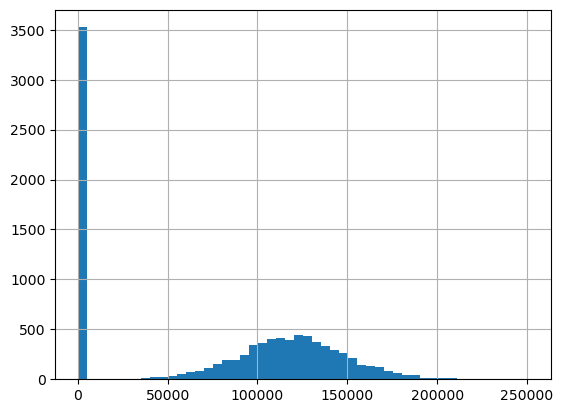

In [6]:
# First, Pearson's correlation assumes normal distribution of data so let's test that
data.balance.hist(bins=50)
normaltest(data.balance)

NormaltestResult(statistic=np.float64(9.065272958909903), pvalue=np.float64(0.010752290477228917))

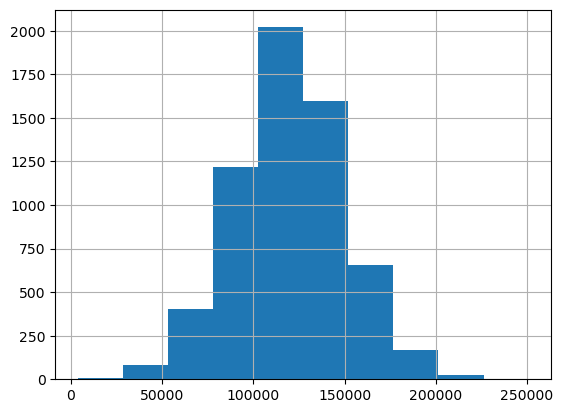

In [7]:
# Not great for balance. However, we can see that this lack of normality is likely due to the spike at 0
data.balance[data.balance > 0].hist()
normaltest(data.balance[data.balance > 0])

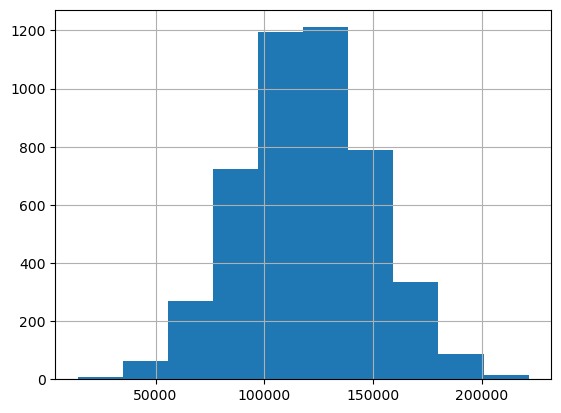

In [8]:
# Also not incredible, but this is a better p-value. Our aim is to reject the null hypothesis
# and for this we need a p-value >= 0.05. We may also want to consider that this subset of the data
# corresponds to both exited and current customers
data.balance[(data.balance > 0) & (data.Exited == 0)].hist()
normaltest(data.balance[(data.balance > 0) & (data.Exited == 0)])
# This subset of the data is normally distributed
balance_exit_mask = (data.balance > 0) & (data.Exited == 0)

Best fitting distribution: uniform
Best p value: 6.546246832247109e-29
Parameters for the best fit: (0.0, 10.0)


('uniform', np.float64(6.546246832247109e-29), (0.0, 10.0))

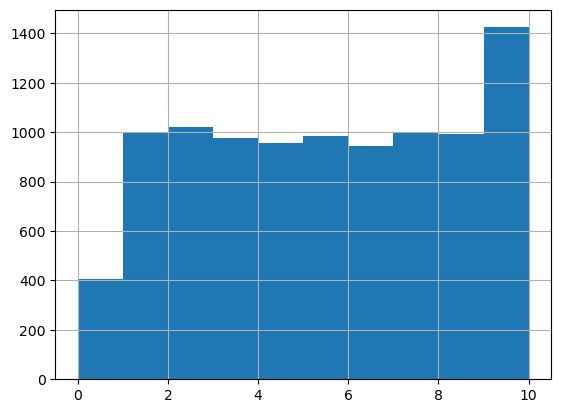

In [9]:
# Testing the distribution of tenure
data.tenure.hist()
get_best_distribution(data.tenure, quiet=True)
# I think it's fair to say that tenure is not a predictably distributed variable

>We can't use Pearson as it assumes normally distributed data for both variables. Also, if we wanted to include multiple variables later we would be limited to normal data. We have other correlations available to us that don't assume normality

In [115]:
from scipy.stats import spearmanr, kendalltau

## Spearman's Rank Correlation
stat, p_val = spearmanr(data.balance[balance_exit_mask], data.tenure[balance_exit_mask])
stat, p_val

(np.float64(0.001113100181782897), np.float64(0.9392271316651565))

In [11]:
## Kendall-Tau
stat, p_val = kendalltau(data.balance[balance_exit_mask], data.tenure[balance_exit_mask])
stat, p_val

(np.float64(0.0007395770664157445), np.float64(0.9421364109769748))

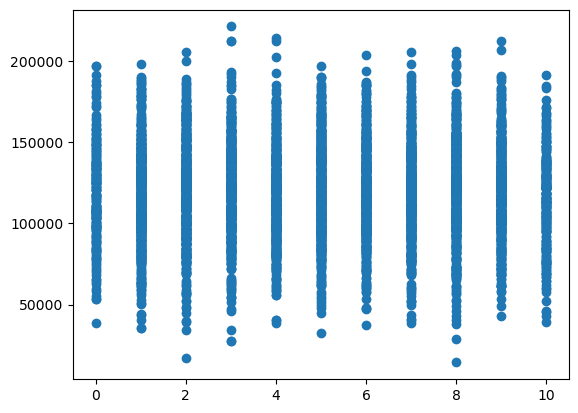

In [12]:
plt.scatter(data.tenure[balance_exit_mask], data.balance[balance_exit_mask])

> With all of this said, I think I should start looking at a scatter plot of two variables before I try to do all of this other fancy stuff so I can get a vibe for whether or not I expect there to be any correlation
>
> For both Spearman's and Kendall-Tau correlation, there is very little correlation. I think we could do just about anything and we would still find that there is not much relationship between balance and tenure.

### Other attributes that are related to the balance

In [13]:
# Let's find out what data type each attribute is, then test univariate correlation with balance
from scipy.stats import pointbiserialr, kruskal
from scikit_posthocs import posthoc_conover
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
le = LabelEncoder()

# Masks to consider
non_zero_mask = data.balance > 0
top_5_percent_balance_mask = data.balance >= data.balance.quantile(0.95)
top_1_percent_balance_mask = data.balance >= data.balance.quantile(0.99)

masks = [data.balance >= 0, balance_exit_mask, non_zero_mask, top_5_percent_balance_mask, top_1_percent_balance_mask]

corrs = []

for col in data.columns:
    if col == 'balance':
            continue
    # Masks are used to determine correlations under other circumstances
    for index, mask in enumerate(masks):
        match data[col].dtype:
            case np.int64:
                # Is it boolean?
                if data[col].isin([1, 0]).all():
                    # Perform Point-Biserial correlation
                    corrs.append((index, col, *pointbiserialr(data[col][mask], data.balance[mask])))
                else:
                    corrs.append((index, col, *spearmanr(data[col][mask], data.balance[mask])))
            case np.float64:
                corrs.append((index, col, *spearmanr(data[col][mask], data.balance[mask])))
            case _:
                # For 2 categories like M/F, use point-biserial again
                if len(data[col].unique()) == 2:
                    corrs.append((index, col, *pointbiserialr(le.fit_transform(data[col][mask]), data.balance[mask])))
                    continue
    
                # For more, like Geography, use Kruskal-Wallis
                groups = []
                for distinct in data[col].unique():
                    groups.append(data.balance[(mask) & (data[col] == distinct)])
                
                if len(groups) > 2:
                    corrs.append((index, col, posthoc_conover(groups), *kruskal(*groups)))

[corr for corr in corrs if corr[-1] <= 0.05]

[(0,
  'Exited',
  np.float64(0.11896140697736032),
  np.float64(6.122803902633952e-32)),
 (3,
  'Exited',
  np.float64(0.16560748325223446),
  np.float64(0.000245572872689797)),
 (4,
  'Exited',
  np.float64(0.24354735874679503),
  np.float64(0.015667596831785847)),
 (2,
  'gender',
  np.float64(0.025561647920796064),
  np.float64(0.044408749626897885)),
 (0,
  'age',
  np.float64(0.03308824341635088),
  np.float64(0.0011109894766512805)),
 (3,
  'Own_car',
  np.float64(-0.09163067356617759),
  np.float64(0.04347857948121741)),
 (0,
  'Geography',
                 1              2              3
  1   1.000000e+00   4.769198e-01  1.522276e-282
  2   4.769198e-01   1.000000e+00  1.004038e-222
  3  1.522276e-282  1.004038e-222   1.000000e+00,
  np.float64(1352.4860269531816),
  np.float64(2.0482870605900074e-294)),
 (4,
  'Total_income',
  np.float64(0.20821348617031213),
  np.float64(0.03965083262577849)),
 (4,
  'credit_card',
  np.float64(-0.22003550197140215),
  np.float64(0.0294769

We have a weak correlation with high significance (p <= 0.05) between gender, age, Geography, Housing_type and balance! Let's plot them just to see them

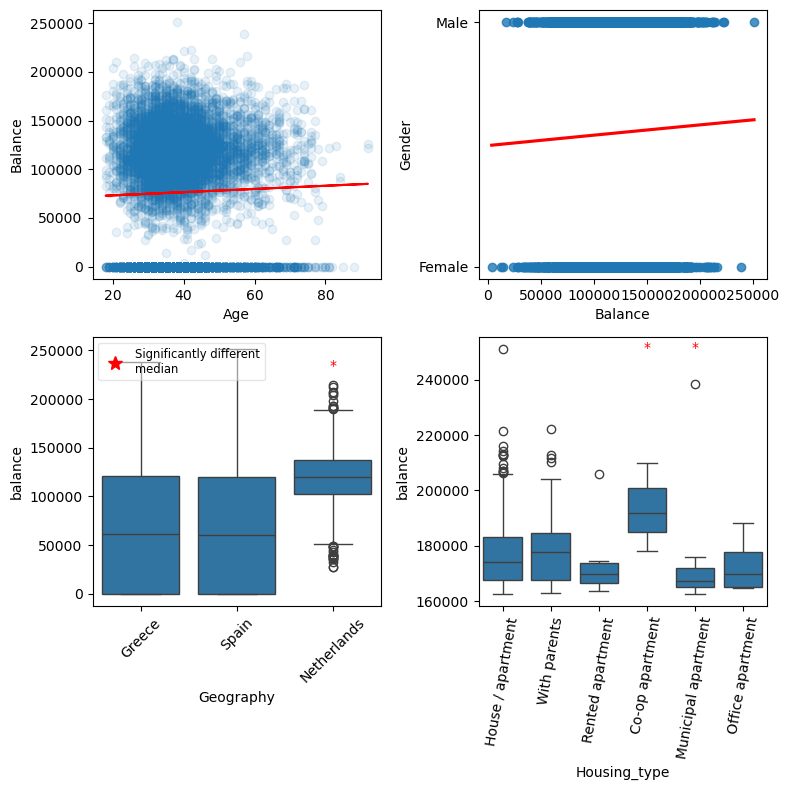

In [116]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.lines as mlines
lm = LinearRegression()
y = data.balance
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

X = data[['age']]

fit = lm.fit(X, y)
pred = fit.predict(X)
ax1.scatter(X, y, alpha=0.1)
ax1.plot(X, pred, c='red')
ax1.set_ylabel('Balance')
ax1.set_xlabel('Age')

X = le.fit_transform(data[['gender']][non_zero_mask])

fit = lm.fit(X.reshape(-1,1), y[non_zero_mask])
pred = fit.predict(X.reshape(-1,1))
sns.regplot(x=y[non_zero_mask], y=X, logistic=True, ax=ax2, 
            ci=None, line_kws={'color': 'red'})

ax2.set_xlabel('Balance')
ax2.set_ylabel('Gender')
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Female', 'Male'])

sns.boxplot(x=data.Geography, y=data.balance, ax=ax3)
ax3.tick_params(axis='x', labelrotation=45)
ax3.text(2, 230000, '*', c='red', horizontalalignment='center')

sns.boxplot(x=data.Housing_type[top_5_percent_balance_mask], y=data.balance[top_5_percent_balance_mask], ax=ax4)
ax4.tick_params(axis='x', labelrotation=80)
ax4.text(3, 250000, '*', c='red', horizontalalignment='center')
ax4.text(4, 250000, '*', c='red', horizontalalignment='center')

asterisk = mlines.Line2D([], [], color='red', marker='*', linestyle='None',
                          markersize=10, label='Significantly different\nmedian')
ax3.legend(handles=[asterisk], loc='upper left', framealpha=0.5, fontsize='small')

fig.tight_layout()
plt.savefig('images/assoc_1.png')

We might also consider the Own_car, Total_income and credit_card atttributes if we consider correlation with high-value customers (top 1% and top 5% balances)

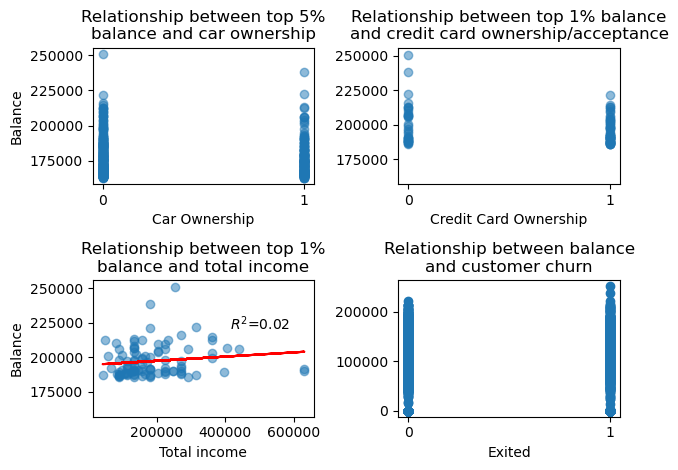

In [15]:
fig = plt.figure()

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# Own_car
X = data[['Own_car']][top_5_percent_balance_mask]

ax1.scatter(X, y[top_5_percent_balance_mask], alpha=0.5)

ax1.set_title('Relationship between top 5%\nbalance and car ownership')
ax1.set_ylabel('Balance')
ax1.set_xlabel('Car Ownership')
ax1.set_xticks([0, 1])

# credit_card
X = data[['credit_card']][top_1_percent_balance_mask]

ax2.scatter(X, y[top_1_percent_balance_mask],alpha=0.5)

ax2.set_title('Relationship between top 1% balance\nand credit card ownership/acceptance')
ax2.set_xlabel('Credit Card Ownership')
ax2.set_xticks([0,1])
ax2.set_ylim(160000*0.98, data.balance.max()*1.02)

# Total_income
X = data[['Total_income']][top_1_percent_balance_mask]

fit = lm.fit(X, y[top_1_percent_balance_mask]) 
pred = fit.predict(X)
ax3.scatter(X, y[top_1_percent_balance_mask], alpha=0.5)
ax3.plot(X, pred, c='red')
ax3.text(500000, 220000,
         f'$R^2$={fit.score(X, y[top_1_percent_balance_mask]):.2f}', 
         horizontalalignment='center')

ax3.set_title('Relationship between top 1%\nbalance and total income')
ax3.set_ylim(160000*0.98, data.balance.max()*1.02)
ax3.set_ylabel('Balance')
ax3.set_xlabel('Total income')

X = data[['Exited']]
ax4.scatter(X, y)

ax4.set_title('Relationship between balance\nand customer churn')
ax4.set_xlabel('Exited')
ax4.set_xticks([0,1])

fig.tight_layout()

### Churning Security Closing Remarks
#### Relationship between Tenure and Balance
Correlation measures (Spearman and Kendall-Tau) indicate that there is no statistically significant (p-value <= 0.05) correlation between tenure and balance attributes - i.e. Tenure is not a good indicator of balance and thus does not provide us with a way to identify high-value customers and provide them with higher security.

Spearman and Kendall-Tau are both measures of correlation that do not require both attributes to be normally distributed (like Pearson's correlation does). These were necessitated because tenure does not exhibit Gaussian (or any other common) distribution and would invalidate the Pearson's correlation.

#### Other attributes and their correlation with Balance
In order to investigate other attributes, I needed to determine what subpopulations of the customer base could be interesting to us, and could make our results clearer. To this end, I created masks to filter out zero-balance entries, churned customers, those with a value in the 99th percentile, and those in the 95th percentile. I also tested the correlation of attributes with no filter at all.

Using these 5 masks, I isolated 7 correlations that had statistical significance - gender (p=0.044), age(0.0011), geography (p=2.05$\times 10^{-294}$), housing type (p=0.026), car ownership (p=0.04), credit card ownership (p=0.03) and total income (p=0.04) and customer churn (p=6.12$\times 10^{-32}$). However, whilst these correlations are statistically signficiant (p <= 0.05), the correlations themselves are relatively weak, with the highest absolute value for either Spearman or Point-Biserial correlations of statistically significant results being 0.22. For nominal attributes with more than 2 unique values (like Geography and Housing type), a Kruskal-Wallis H-test was used to test for statistical difference between groups and results with a p-value <= 0.05 were tested ad-hoc using the Conover-Iman test to determine which pairwise relations were statistically significantly different. For the Geography feature, it was found that you were more likely to have a higher balance if you were from the Netherlands, and for the Housing type, higher earners were more likely to live in Co-op housing, interestingly

## Age
> Determine whether ‘age’ is a good predictor of the likelihood of credit card eligibility and clearly demonstrate this against two of the other attributes in the data set. Clearly state which other attributes were selected as comparators and justify these choices.

In order to determine how good 'age' is as a predictor, it makes sense that this is a classification problem, since the target attribute is a binary value. I should choose an effective classification model to perform this with and evaluate the effectiveness of any model I choose. Then, I should choose two other attributes that could be predictors of credit card eligibility. These should be chosen through research, rather than statistically.

### Data Cleaning and Prepping for Logistic Regression
Logistic regression is interpretable as either a probabilistic or deterministic classification technique (interesting article [here](https://medium.com/analytics-vidhya/probabilistic-and-deterministic-mindsets-of-logistic-regression-4786cb126ce3)). For our purposes, it will be probabilistic, returning a probability of an object belonging to the target class. It does not perform well with missing values, and is susceptible to high complexity. Luckily, we'll only be using a single attribute as a determinant of the target attribute so complexity is low.

Assumptions made by logistic regression models:
- Instances of independent variables must be measured independently (i.e. not from repeated measurement)
- Little to no multicollinearity between independent variables
  - We don't need to check these two as we are only using one independent variable
- Large sample size
  - At least 10 cases of the least likely value of the independent variable
  - e.g. for 5 independent variables, with a likelihood of 10% for the least likely independent variable, the sample size should be at least 10*5/0.1 = 500

In [31]:
# Data cleaning
len(data.age[(data.age.isna()) | (data.age < 18)])    # Can confirm no null values and no under-18s
# Also no null values for credit_card or 1 < values < 0
len(data.credit_card[(data.credit_card.isna()) | ((data.credit_card > 1) | (data.credit_card < 0))])

# Minimum sample size
least_likely = min(len(data.credit_card[data.credit_card == 0]) / len(data), len(data.credit_card[data.credit_card == 1]) / len(data))
len(data) > 10/least_likely

# All clean!
# Can also confirm there are no null values anywhere in the data:
data.notna().all().all()

box_tidwell('age', 'credit_card', data)

Optimization terminated successfully.
         Current function value: 0.606864
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            credit_card   No. Observations:                 9709
Model:                          Logit   Df Residuals:                     9706
Method:                           MLE   Df Model:                            2
Date:                Sun, 27 Oct 2024   Pseudo R-squ.:               8.057e-05
Time:                        10:22:56   Log-Likelihood:                -5892.0
converged:                       True   LL-Null:                       -5892.5
Covariance Type:            nonrobust   LLR p-value:                    0.6220
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0633      0.482      2.205      0.027       0.118       2.009
age           -0.0154      0.

(9709, 22)

              precision    recall  f1-score   support

           0       0.30      0.46      0.36       930
           1       0.72      0.55      0.62      2274

    accuracy                           0.53      3204
   macro avg       0.51      0.51      0.49      3204
weighted avg       0.59      0.53      0.55      3204

Optimization terminated successfully.
         Current function value: 0.606867
         Iterations 5
              Coef.  Std.Err.          z         P>|z|    [0.025    0.975]
Intercept  0.947027  0.085331  11.098231  1.279507e-28  0.779781  1.114274
age       -0.001993  0.002111  -0.944365  3.449834e-01 -0.006131  0.002144


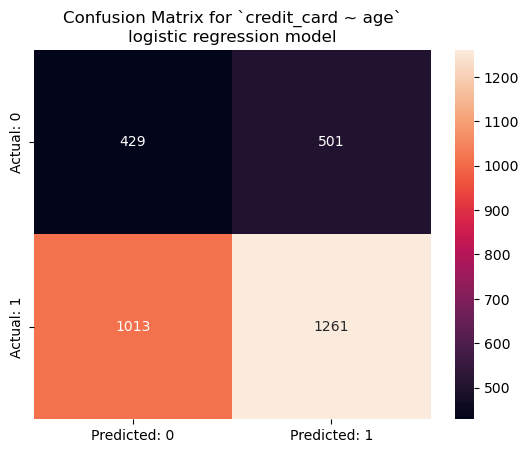

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

logit = LogisticRegression(class_weight='balanced')

# Split data
X_train, X_test, y_train, y_test = train_test_split(data[['age']], data.credit_card, 
                                                    test_size=0.33, random_state=16)

# Train model
model = logit.fit(X_train, y_train)

# Predict probability of credit_card=1 and outcomes
y_pred_prob = model.predict_proba(X_test)[:,1]
y_preds = model.predict(X_test)

# Evaluation using Confusion Matrix
conf_mat = confusion_matrix(y_test, y_preds)
sns.heatmap(pd.DataFrame(conf_mat, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1']), fmt='d', annot=True)

# Evaluation using Classifcation Report
print(classification_report(y_test, y_preds))

# Significance of model prediction
smMod = lg('credit_card ~ age', data=data).fit()
print(smMod.summary2().tables[1])
# p=0.345

plt.title('Confusion Matrix for `credit_card ~ age`\nlogistic regression model')
plt.savefig('./images/age_heatmap.png')

So the precision and accuracy of 0-value prediction is not great, and the overall accuracy isn't amazing either. Recall for 0s was 46% and that for 1s is 55%. Overall accuracy is 53%, which is poor, really. Even taking the mean of 15 cross validations of the unsplit data results in about 53% accuracy.

The heatmap is a simple illustration of true negatives, true positives, false negatives and false positives, taken from the confusion matrix. It is this confusion matrix that we derive the precision and accuracy from.

What this tells us is that, about 53% of the time, we can expect age to be an effective classifier of credit card eligibility. The p-value associated with the logistic regression of credit card eligibility and age is 0.345, which is not significant. The relationship between age and credit card acceptance is weak and model fitting has produced near-random classification

### Other predictors of credit_card
How can I choose which other attributes I want to look at? I thought I would do it using research but like, I don't know what to look for.

With a little bit of a search, it makes a lot of sense that I should be looking at income and credit score, but I'm also curious about the age of the account.

LOGISTIC REGRESSION LET'S GO. Maybe I can have a look at some multidimensional analysis, hoping that most of the attributes I use aren't collinear. I wonder if there's a test for that. (VIF - variance inflation factor)

---

I can actually just go ahead and do a multidimensional logistic regression using all of the useful features. We want to find out ahead of time which features we can expect to make an impact on the regression and we can do this using t-tests and chi-squared tests.

In [67]:
from scipy.stats import chi2_contingency, pearsonr
from statsmodels.stats.outliers_influence import variance_inflation_factor

features = data.columns[data.columns != 'credit_card']

measures = []
p_vals = []
stats = []
significant = []
vif = [np.nan]*len(features)

for index, feature in enumerate(features):
    
    if data[feature].isin([0,1]).all():
        # Boolean - Chi Square
        obs = pd.crosstab(data[feature], data.credit_card)
        
        stat, p, _, _ = chi2_contingency(obs)
        
        measures.append('chi2')

        df = data.drop(['gender', 'Geography','Income_type','Education_type', 'Family_status', 'Housing_type', 'Occupation_type'], axis=1)
        vif[index] = variance_inflation_factor(df.values, df.columns.get_loc(feature))

    elif data[feature].dtype in [np.int64, np.float64]:
        # Continuous - Point-Biserial
        stat, p = pointbiserialr(data[feature], data.credit_card)

        measures.append('point-biserial')
        df = data.drop(['gender', 'Geography','Income_type','Education_type', 'Family_status', 'Housing_type', 'Occupation_type'], axis=1)
        vif[index] = variance_inflation_factor(df.values, df.columns.get_loc(feature))

    else: 
        if len(data[feature].unique()) == 2:
            obs = pd.crosstab(data[feature], data.credit_card)
            stat, p, _, _ = chi2_contingency(obs)

            measures.append('chi2')

        else:
            groups = []
            for distinct in data[feature].unique():
                groups.append(data.credit_card[data[feature] == distinct])
            
            stat, p = kruskal(*groups)
    
            measures.append('kruskal')

    stats.append(stat)
    p_vals.append(p)
    significant.append(p <= 0.1)

analyses = pd.DataFrame(index=features)
analyses['measure'] = measures
analyses['statistic'] = stats
analyses['p-val'] = p_vals
analyses['significant'] = significant
print(vif)
analyses['VIF'] = vif

analyses

[np.float64(1.3840542779984117), nan, np.float64(13.247993412569942), np.float64(1.0361449224238868), np.float64(1.6937941506744962), np.float64(3.0065875490079517), nan, np.float64(19.164874402730547), np.float64(3.8667712190991335), np.float64(2.485700541585275), np.float64(1.5737706134415), np.float64(1.3756810354596327), np.float64(3.6415875364841344), np.float64(4.499154967013411), np.float64(2.1696803915490013), nan, nan, nan, nan, nan, np.float64(1.1618091442975929)]


,measure,statistic,p-val,significant,VIF
Exited,chi2,0.493381,0.482423,False,1.384054
gender,chi2,0.515648,0.472704,False,NaN
age,point-biserial,-0.009585,0.345001,False,13.247993
term_deposit,chi2,0.000000,1.000000,False,1.036145
Own_car,chi2,0.134055,0.714264,False,1.693794
Own_property,chi2,2.824495,0.092836,True,3.006588
Geography,kruskal,2.273491,0.320861,False,NaN
credit_score,point-biserial,-0.009875,0.330608,False,19.164874
tenure,point-biserial,0.023047,0.023149,True,3.866771
balance,point-biserial,-0.015291,0.131918,False,2.485701


              precision    recall  f1-score   support

           0       0.31      0.47      0.37       930
           1       0.72      0.56      0.63      2274

    accuracy                           0.54      3204
   macro avg       0.51      0.52      0.50      3204
weighted avg       0.60      0.54      0.56      3204



np.float64(0.5195723513112227)

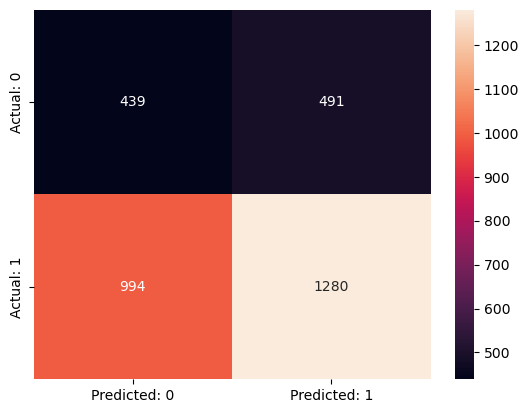

In [96]:
from sklearn.metrics import roc_auc_score
logit = LogisticRegression(class_weight='balanced')

dummy_data = pd.get_dummies(data, columns=['gender', 'Geography', 'Income_type',
                                           'Education_type', 'Family_status', 'Housing_type', 
                                           'Occupation_type']).drop(['credit_card'] + analyses.index[analyses.VIF > 5].tolist(), axis=1)

X_train, X_test, y_train, y_test = train_test_split(dummy_data, data.credit_card, 
                                                    test_size=0.33, random_state=16)

model = logit.fit(X_train, y_train)

preds = model.predict(X_test)
y_score = model.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, preds)
sns.heatmap(pd.DataFrame(conf_mat, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1']), annot=True, fmt='d')

print(classification_report(y_test, preds))

roc_auc_score(y_test, y_score[:, 1])

<BarContainer object of 26 artists>

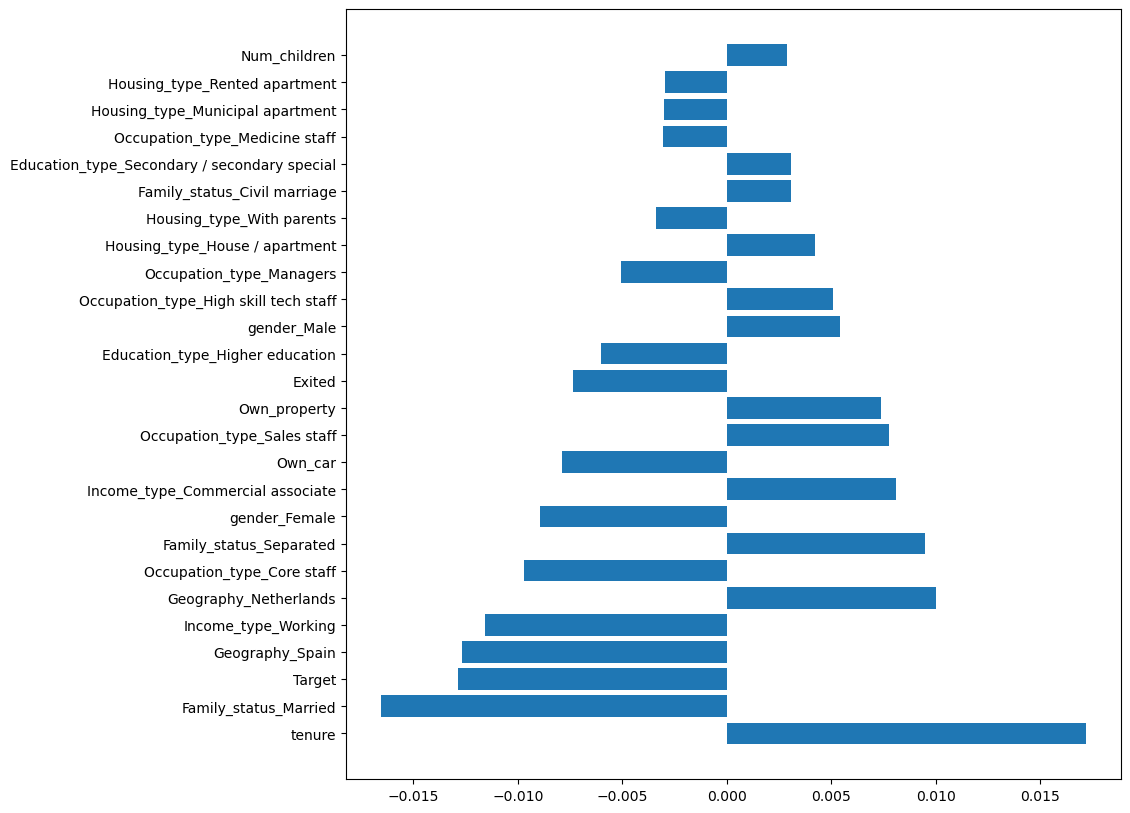

In [87]:
importance = np.argsort(np.abs(model.coef_.flatten()))[:30:-1]

fig, ax = plt.subplots(1, 1, figsize=(10,10))
plt.barh(dummy_data.columns[importance], model.coef_.flatten()[importance])

The 20 most impactful *values* for estimating the logistic regression. I can probably use the 2 highest values (Account_length and Years_employed) to obtain a good logistic regression when predicting credit_card eligibility. As we expect, tenure also plays an important role, given that it had relatively high association earlier on

              precision    recall  f1-score   support

           0       0.30      0.34      0.32       930
           1       0.72      0.68      0.70      2274

    accuracy                           0.58      3204
   macro avg       0.51      0.51      0.51      3204
weighted avg       0.60      0.58      0.59      3204



np.float64(0.5110434930632395)

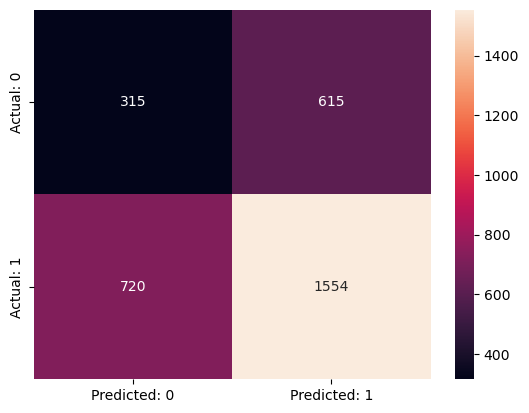

In [111]:
dummy_data.columns = dummy_data.columns.str.replace(' ', '_')
X_train, X_test, y_train, y_test = train_test_split(dummy_data[['Own_property']], data.credit_card, test_size=0.33, random_state=16)

model = logit.fit(X_train, y_train)
preds = model.predict(X_test)
y_score = model.predict_proba(X_test)

conf_mat = confusion_matrix(y_test, preds)

sns.heatmap(pd.DataFrame(conf_mat, columns=['Predicted: 0', 'Predicted: 1'], index=['Actual: 0', 'Actual: 1']), annot=True, fmt='d')

print(classification_report(y_test, preds))

roc_auc_score(y_test, y_score[:, 1])

So, having had a look at the logistic regression, I can confirm that any combination of features results in an accuracy score that is lower than age on its own. However, there are some expected and unexpected features that create accurate predictors of credit_card. The other odd thing is that, when you use the ROC-AUC measure to test the 'randomness' of your predictions (not dissimilar from p-values), it can be determined that a lot of these models are no better than random and sometimes worse than random, even if the accuracy is high. For example, 'age' has an accuracy of 53%, but an ROC-AUC score of 0.507 - marginally better than random. Even looking at the accuracy of the data as a whole, the accuracy is spurious. This would be an indicator of overfitting if the model fit well at all in the first place.